## Auto MPG Data Set
- https://archive.ics.uci.edu/ml/datasets/Auto+MPG
- The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.
- This is a regression problem where we aim to predict the output of a continuous value, ie fuel efficiency.

## Steps perfomed in this SAS notebook:
- Importing Raw Data Files
- Check Data Types of Variables
- Check for Missing Data
- Handle Missing Values
- Check for Duplicate Entries
- Check for Outliers
- Check for Normal Distribution of Variables
- Handle Outliers 
- Check Correlation between Variables
- Log Transformation
- Final Visualizations

## Importing Raw Data Files

In [25]:
libname auto '/folders/myfolders/Project';

proc import Datafile= "~/Project/auto_mpg.csv"
out= auto.original
dbms=csv
replace;
run;

*Ignore error in data import. It is beacuse of '?' values in Horsepower variable;
proc print data= auto.original (obs=5);
run;

Obs,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
1,18,8,307,130,3504,12,70,1,chevrolet chevelle malibu
2,15,8,350,165,3693,11.5,70,1,buick skylark 320
3,18,8,318,150,3436,11,70,1,plymouth satellite
4,16,8,304,150,3433,12,70,1,amc rebel sst
5,17,8,302,140,3449,10.5,70,1,ford torino


## Check Data Types of Variables

In [2]:
proc contents data= auto.original varname;
run;

## Check for Missing Data

In [3]:
*Output shows 6 missing values in horsepower variable;

proc means data=auto.original n nmiss;
run;

Variable,N,N Miss
mpg cylinders displacement horsepower weight acceleration model_year origin,398 398 398 392 398 398 398 398,0 0 0 6 0 0 0 0


In [4]:
*Output shows no missing values in character variables;

proc format;
value $car
' ' = 'Missing'
other = 'Non Missing';

proc freq data=auto.original;
tables _character_ /nocum missing;
format _character_ $car.;
run;

car_name,Frequency,Percent
Non Missing,398,100.00


In [5]:
*Print the row number for which data is missing in horsepower;

data _null_;
set auto.original;
file print;
if horsepower eq '?' then put
_n_= horsepower=;
run;

In [6]:
proc means data=auto.original mean median;
var horsepower;
run;

## Handle Missing Values

In [7]:
*Replacing missing values with mean value of horsepower variable;

data auto.updated;
set auto.original;
if horsepower eq '?' then horsepower=104.47;
run;

* Re-check if there are any missing values now;
proc means data=auto.updated n nmiss;
var horsepower;
run;

## Check for Duplicate Entries

In [8]:
*Log shows 0 duplicates were deleted. So all observations are unique;

proc sort data=auto.updated out=auto.temp3 noduprecs;
by mpg;
run;

## Check for Outliers

In [9]:
*Triming 0.5% values from the top and bottom of the data;

ods output TrimmedMeans=auto.trimmed (keep= Varname mean stdmean df);
proc univariate data = auto.updated noprint trim=0.05 nextrobs=10;
run;
ods output close;

proc print data=auto.trimmed;
run;

Obs,VarName,Mean,StdMean,DF
1,acceleration,15.5198,0.1375,357
2,cylinders,5.4050,0.0942,357
3,displacement,187.3,5.6646,357
4,horsepower,101.7,1.9251,357
5,model_year,76.0112,0.2061,357
6,mpg,23.2229,0.4094,357
7,origin,1.5251,0.0447,357
8,weight,2937.2,45.1982,357


In [10]:
*Restructuring the dataset;

data auto.temp;
set auto.updated;
array vars[*] _numeric_;
length VarName $ 32;
do i=1 to dim(vars);
    Varname=vname(vars[i]);
    Value=vars[i];
    output;
end;
keep Varname Value;
run;

proc print data=auto.temp (obs=10);
run;

Obs,VarName,Value
1,mpg,18
2,cylinders,8
3,displacement,307
4,horsepower,130
5,weight,3504
6,acceleration,12
7,model_year,70
8,origin,1
9,mpg,15
10,cylinders,8


In [11]:
*Checking values 3 Standard Deviation away from the mean;

proc sort data=auto.temp;
by varname;
run;

proc sort data=auto.trimmed;
by varname;
run;

data auto.outlier;
merge auto.temp auto.trimmed;
by varname;
std_dev=stdmean*sqrt(df+1);
length Reason $12.;
if value lt mean-3*std_dev then do;
    reason='Low';
    output;
end;
else if value gt mean+3*std_dev then do;
    reason='High';
    output;
end;
run;

* Print the outlier values and the reason;
proc print data=auto.outlier;
var varname value reason;
run;


Obs,VarName,Value,Reason
1,acceleration,23.5,High
2,acceleration,24.8,High
3,acceleration,23.7,High
4,acceleration,24.6,High
5,horsepower,220.0,High
6,horsepower,215.0,High
7,horsepower,225.0,High
8,horsepower,225.0,High
9,horsepower,215.0,High
10,horsepower,215.0,High



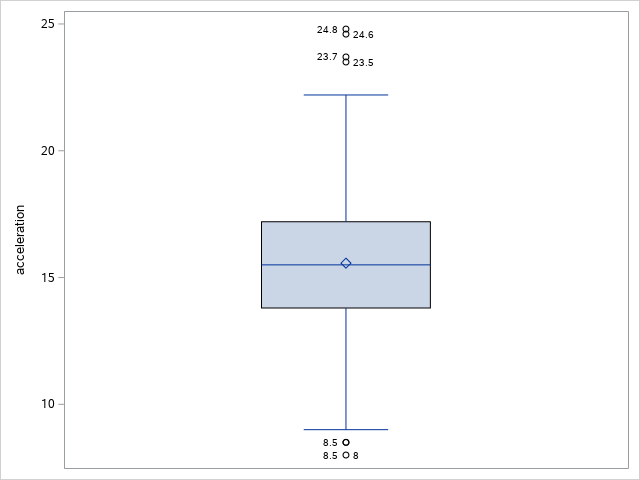

In [12]:
*Check outliers using box plot method;

proc sgplot data= auto.updated;
vbox acceleration /datalabel;
run;


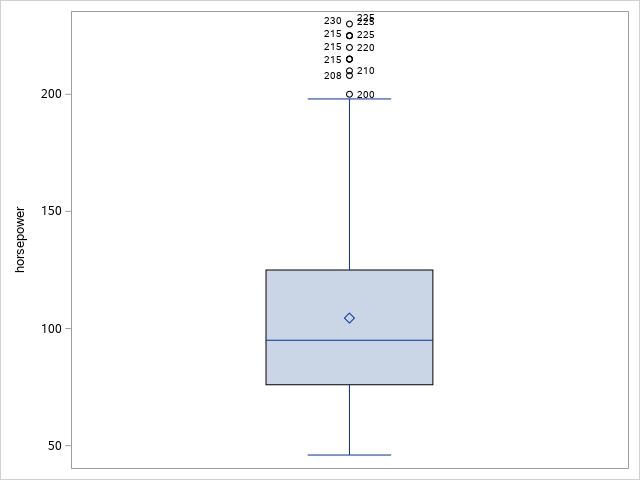

In [13]:
proc sgplot data= auto.updated;
vbox horsepower /datalabel;
run;


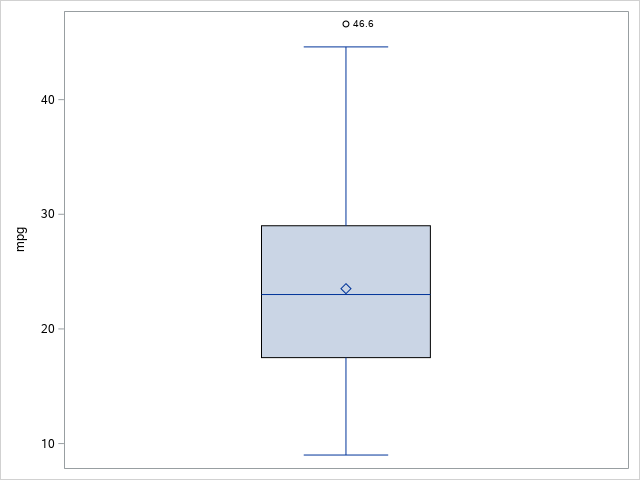

In [14]:
proc sgplot data= auto.updated;
vbox mpg /datalabel;
run;


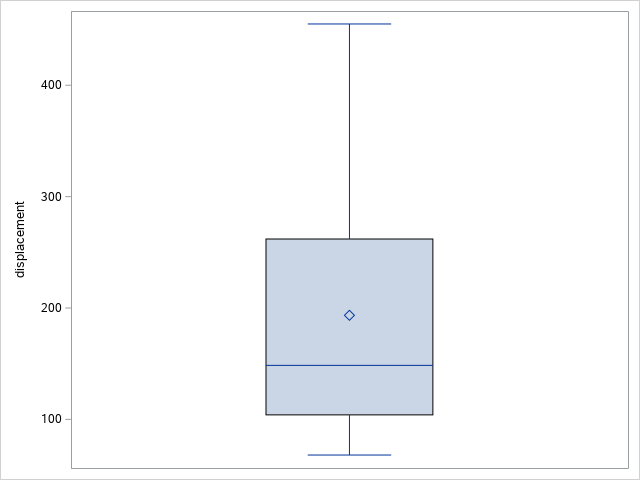

In [15]:
proc sgplot data= auto.updated;
vbox displacement /datalabel;
run;


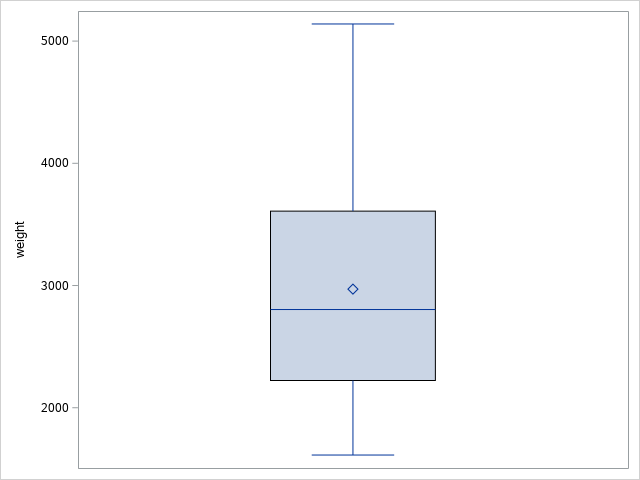

In [16]:
proc sgplot data= auto.updated;
vbox weight /datalabel;
run;

In [17]:
*Detect outliers via IQR method;

proc means data=auto.updated noprint;
var acceleration horsepower mpg;
output out=Tmpo (drop=_type_ _freq_)
Q1=
Q3=
QRange= / autoname;
run;

data _null_;
file print;
set auto.updated(keep=acceleration horsepower mpg);
if _n_ = 1 then set Tmpo;
if acceleration le acceleration_Q1 - 1.5*acceleration_QRange and not missing(acceleration) 
    or acceleration ge acceleration_Q3 + 1.5*acceleration_QRange then
    put "Possible Outlier for acceleration is " acceleration;
else if horsepower le horsepower_Q1 - 1.5*horsepower_QRange and not missing(horsepower) 
    or horsepower ge horsepower_Q3 + 1.5*horsepower_QRange then
    put "Possible Outlier for horsepower is " horsepower;
else if mpg le mpg_Q1 - 1.5*mpg_QRange and not missing(mpg) 
    or mpg ge mpg_Q3 + 1.5*mpg_QRange then
    put "Possible Outlier for mpg is " mpg;
run;

## Handle Outliers

In [18]:
*Only 18 observations have significant outlier values among total 398 observations;
*So the outlier values can be deleted without much impacting the overall dataset;

proc means data=auto.updated noprint;
var acceleration horsepower mpg;
output out=Tmpo (drop=_type_ _freq_)
Q1=
Q3=
QRange= / autoname;
run;

data auto.outlier_removed;
set auto.updated;
if _n_ = 1 then set Tmpo;
if acceleration le acceleration_Q1 - 1.5*acceleration_QRange and not missing(acceleration) 
    or acceleration ge acceleration_Q3 + 1.5*acceleration_QRange then delete;
else if horsepower le horsepower_Q1 - 1.5*horsepower_QRange and not missing(horsepower) 
    or horsepower ge horsepower_Q3 + 1.5*horsepower_QRange then delete;
else if mpg le mpg_Q1 - 1.5*mpg_QRange and not missing(mpg) 
    or mpg ge mpg_Q3 + 1.5*mpg_QRange then delete;
    
keep mpg cylinders displacement horsepower weight acceleration model_year origin car_name;
run;

proc means data=auto.outlier_removed;
run;

Variable,N,Mean,Std Dev,Minimum,Maximum
mpg cylinders displacement horsepower weight acceleration model_year origin,380 380 380 380 380 380 380 380,23.7015789 5.3868421 187.4460526 101.4495263 2933.17 15.6384211 76.1526316 1.5842105,7.5097402 1.6661572 98.1339836 33.0483558 822.7597283 2.4885697 3.6172948 0.8094189,9.0000000 3.0000000 68.0000000 46.0000000 1613.00 9.5000000 70.0000000 1.0000000,44.6000000 8.0000000 429.0000000 198.0000000 5140.00 22.2000000 82.0000000 3.0000000


## Check for Normal Distribution of Variables


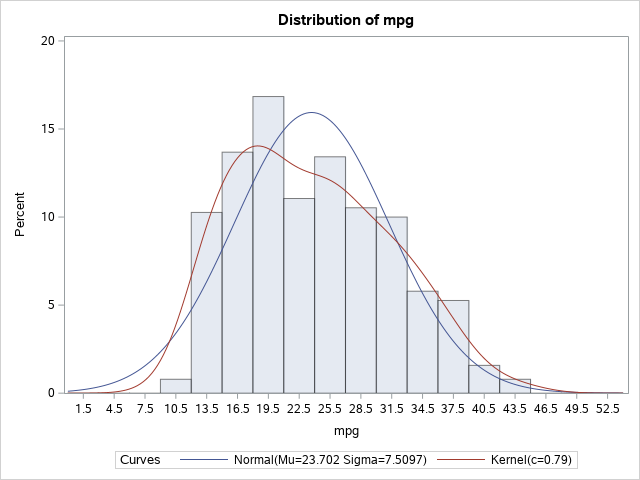
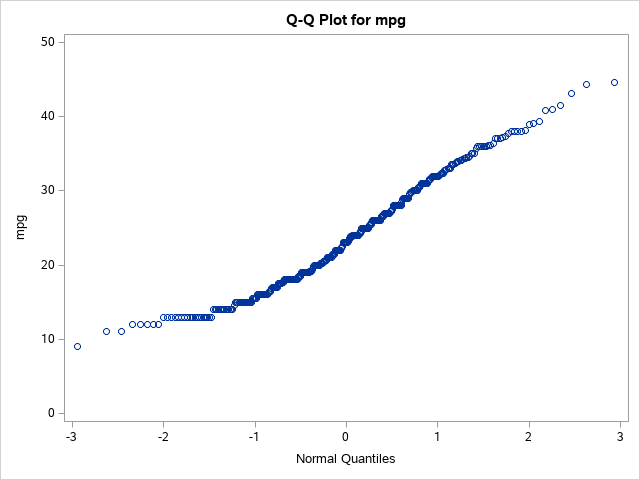
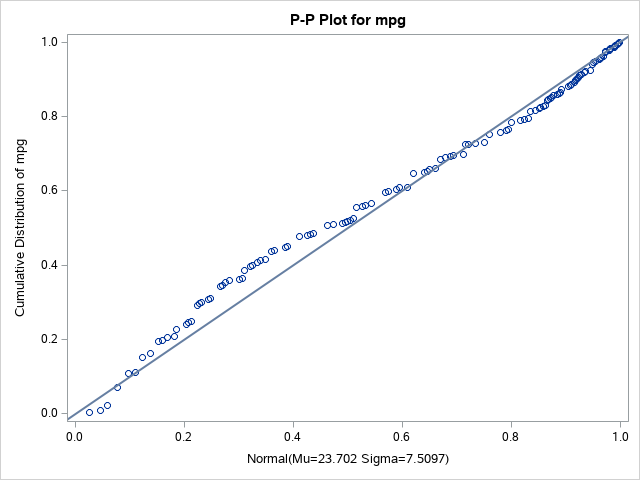
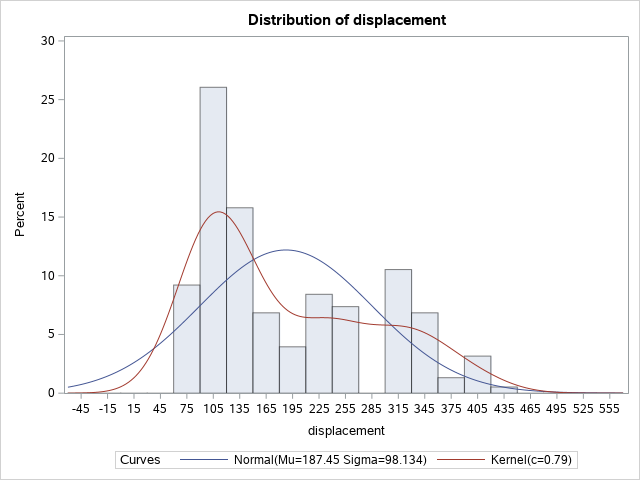
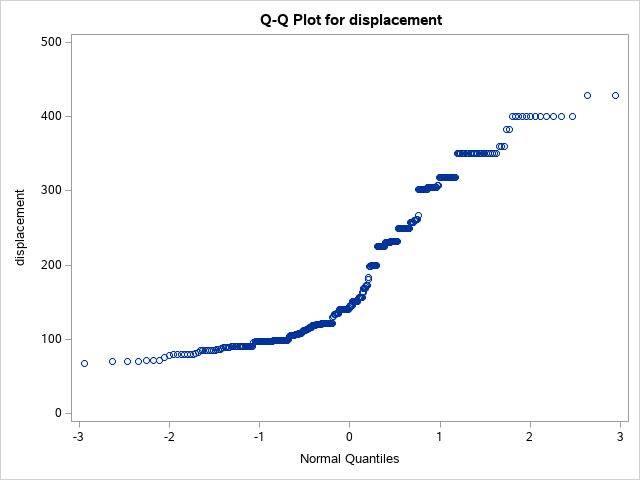
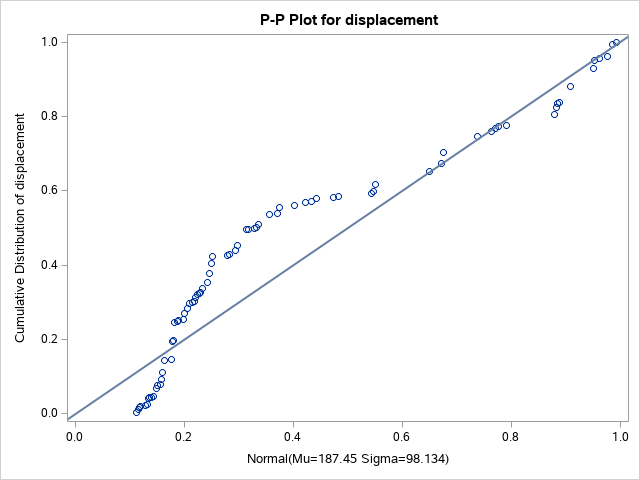
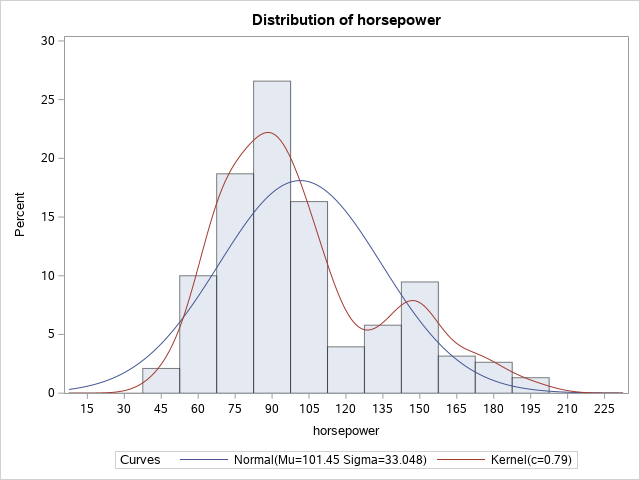
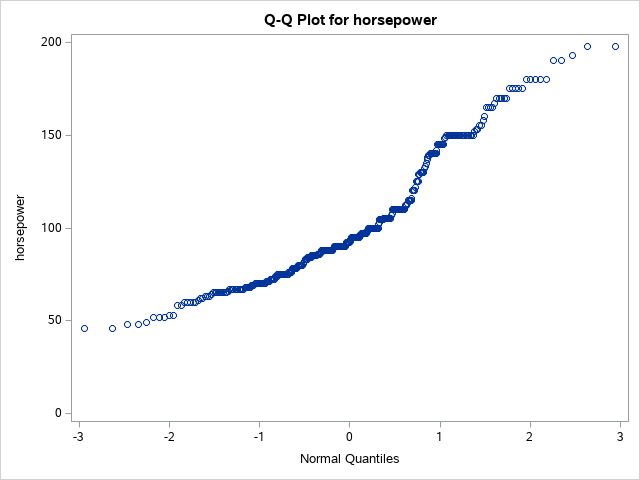
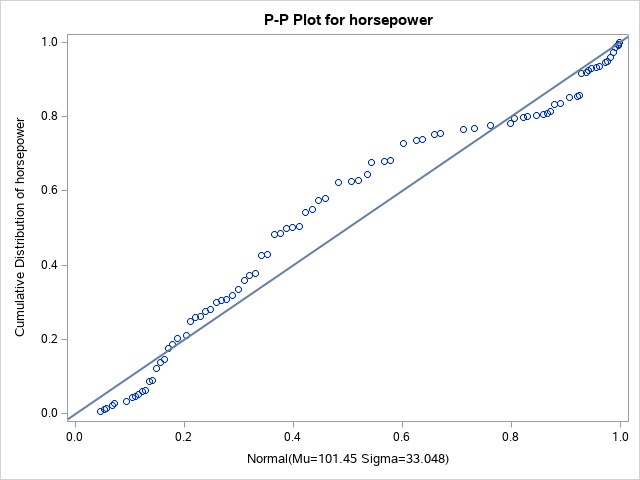
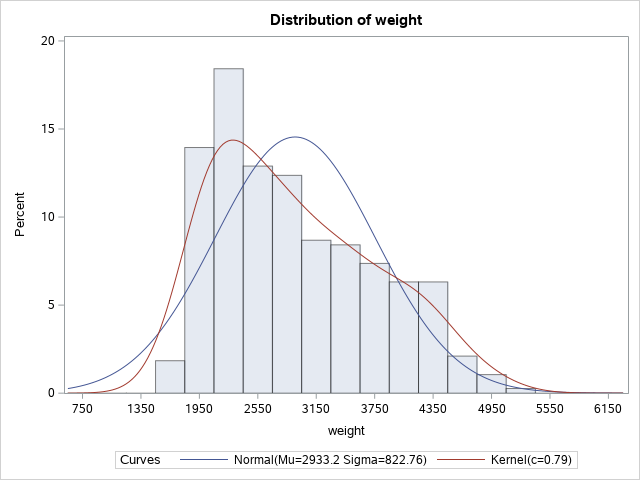
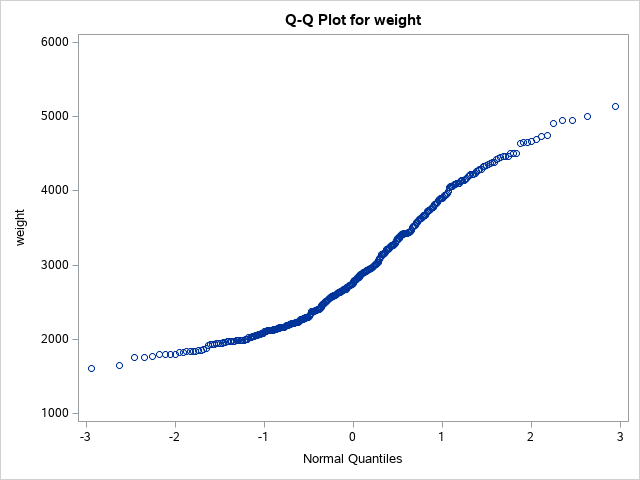
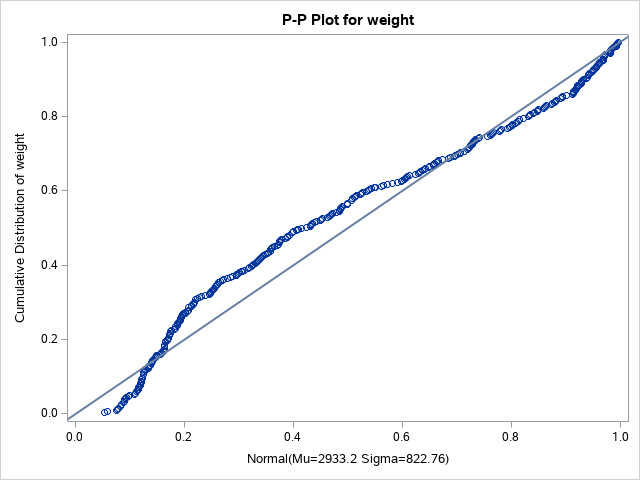
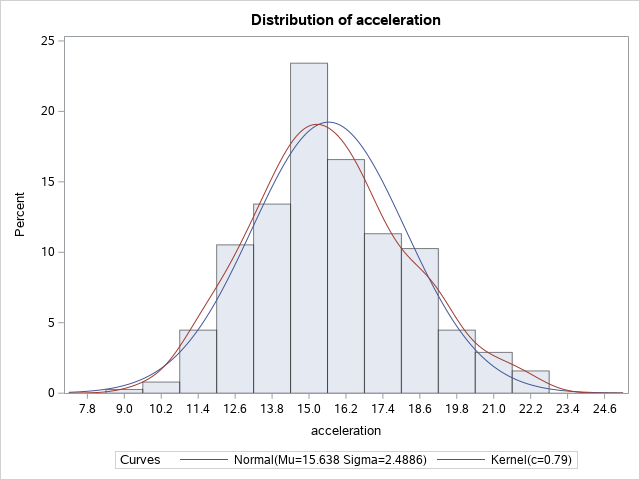
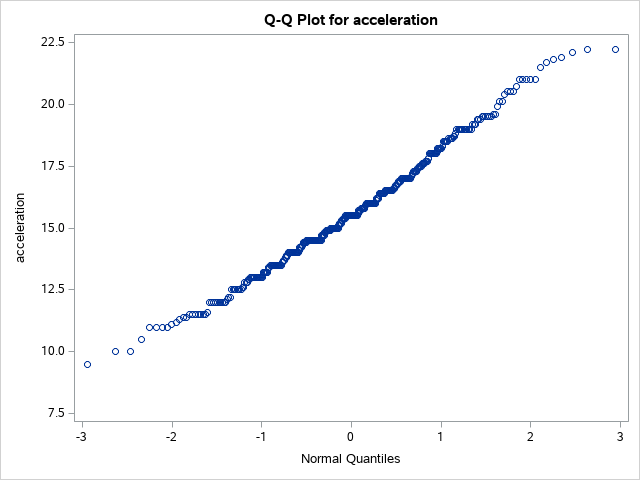
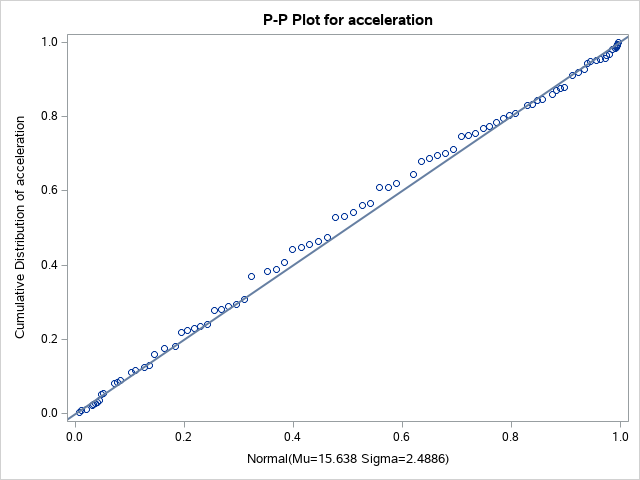

In [19]:
*Check Q-Q and probability plots for checking distribution of variables;

proc univariate data=auto.outlier_removed;
var mpg displacement horsepower weight acceleration;
ppplot;
qqplot;
histogram/ normal kernel;
run;

## Check Correlation between Variables

In [20]:
*Check pearson correlation for linear and spearman correlation for non linear variables;

proc corr data=auto.outlier_removed pearson spearman plots=matrix(nvar=all histogram);
run;

## Log Transformation


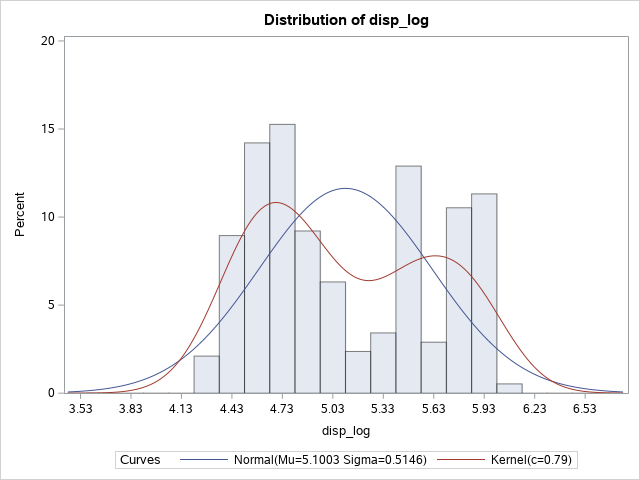
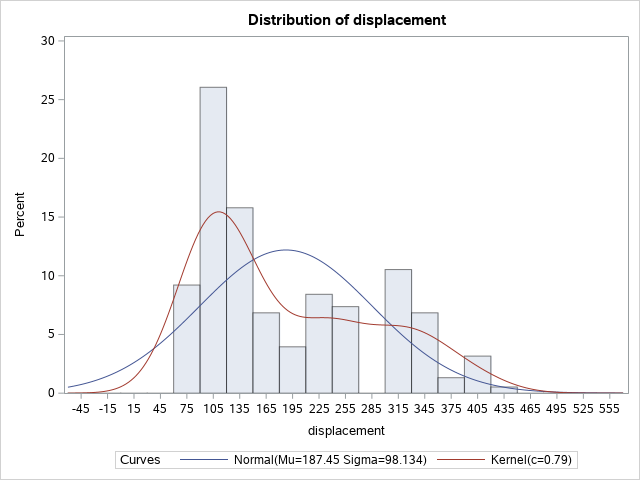

In [21]:
*The log transformation can be used to make highly skewed distributions less skewed;

data auto.log_data;
set auto.outlier_removed;
disp_log = log(displacement);
run;

*Compare the new graphs;
ods select Histogram;
proc univariate data= auto.log_data noprint;
var disp_log displacement;
histogram / kernel normal;
run;


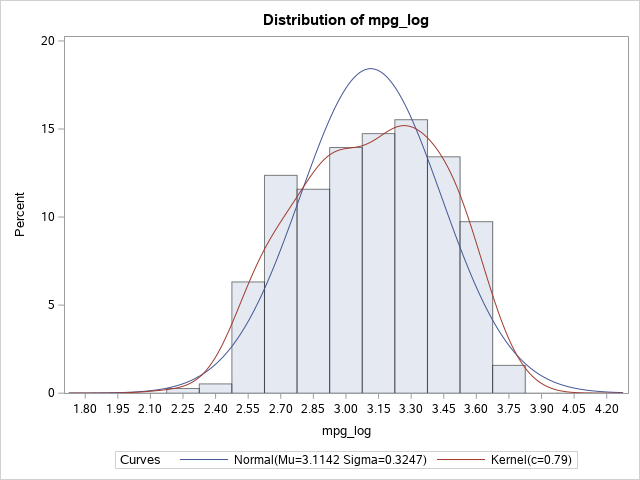
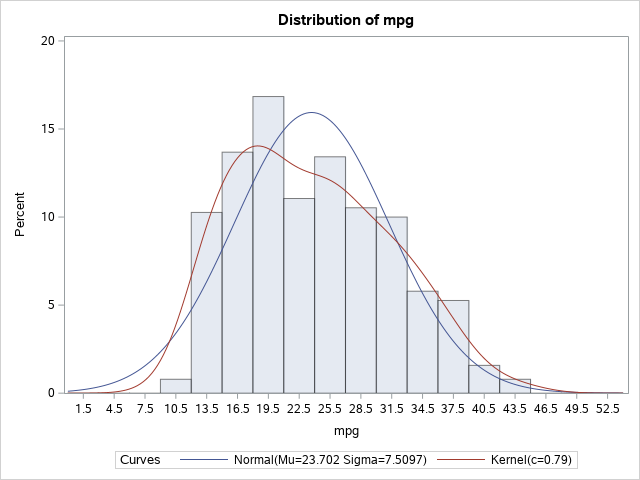

In [22]:
*Apply logarithmic transformation on mpg variable;

data auto.log_data;
set auto.log_data;
mpg_log = log(mpg);
run;

ods select Histogram;
proc univariate data= auto.log_data noprint;
var mpg_log mpg;
histogram / kernel normal;
run;

## Final Visualizations


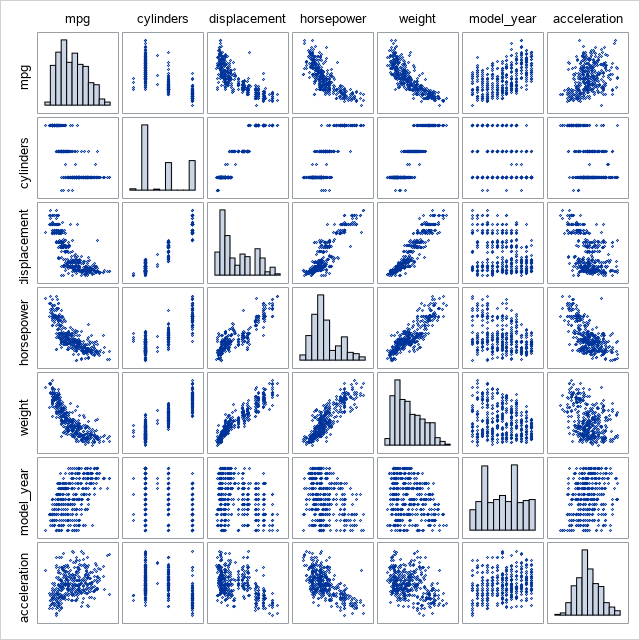

In [23]:
*Plot scatter plots to visualize the relation between varibles;

proc sgscatter data=auto.outlier_removed;
    matrix mpg cylinders displacement horsepower weight model_year acceleration/ diagonal=(histogram);
run;


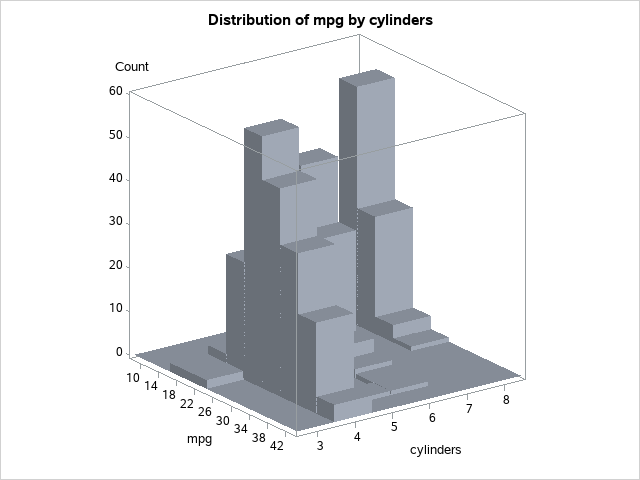
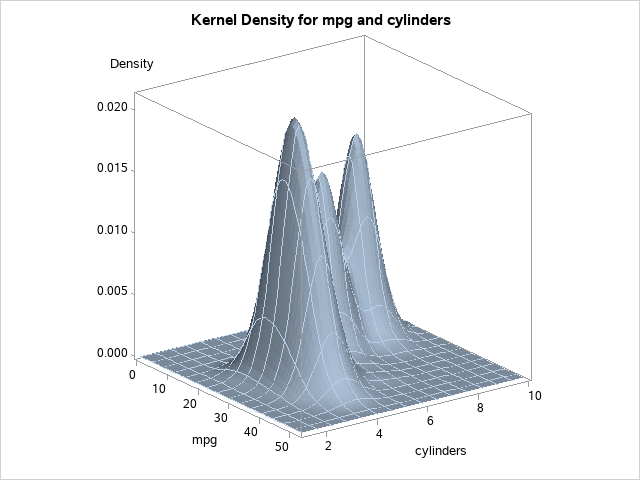
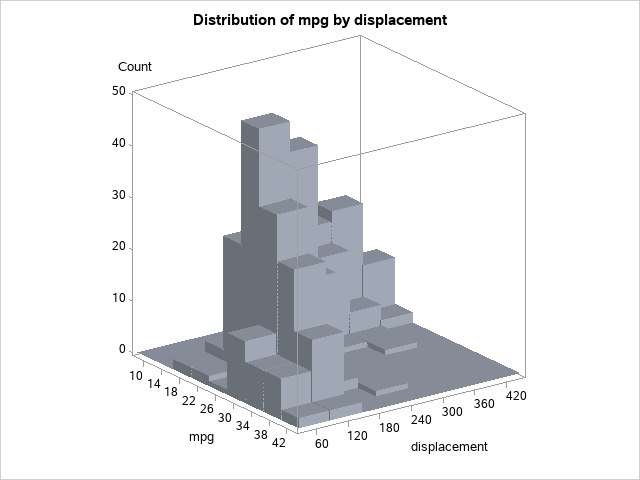
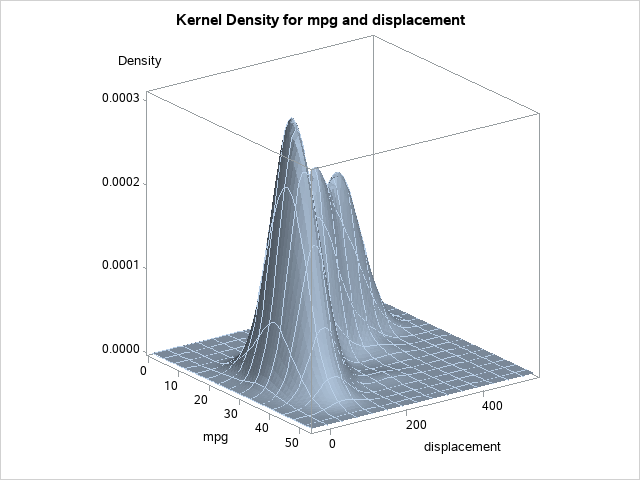
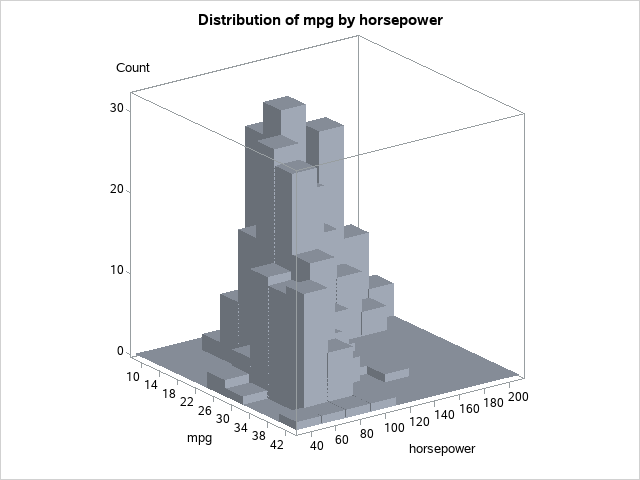
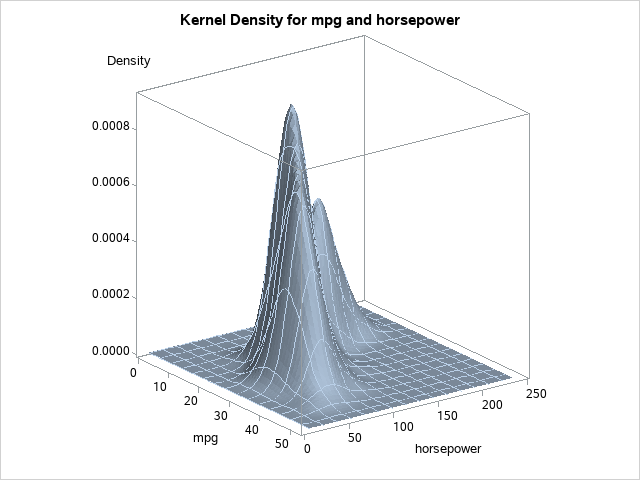
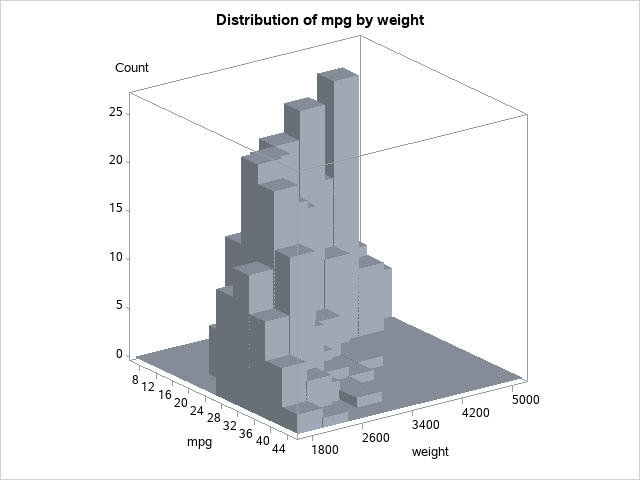
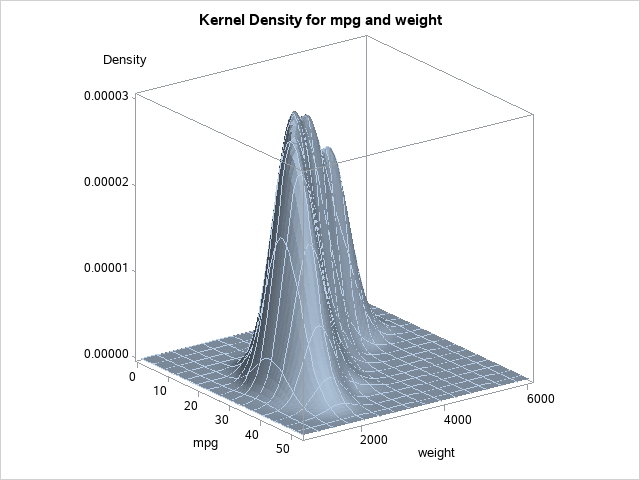
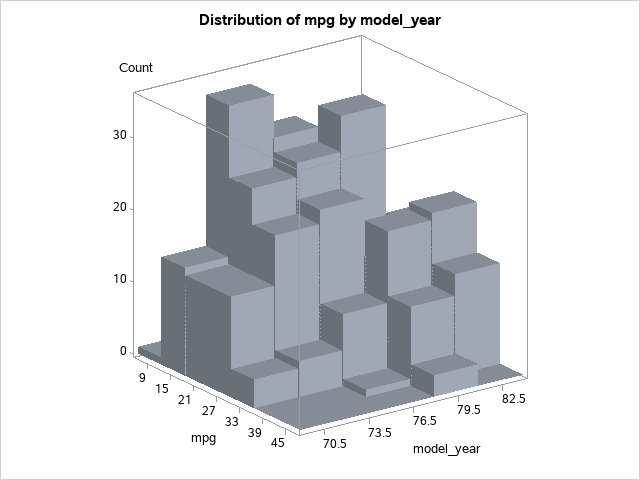
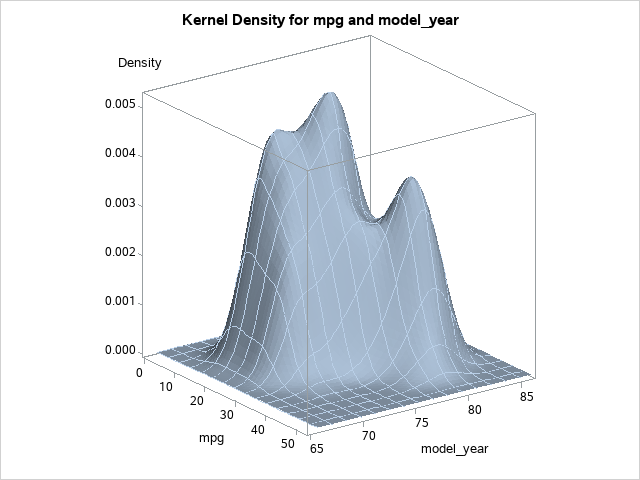
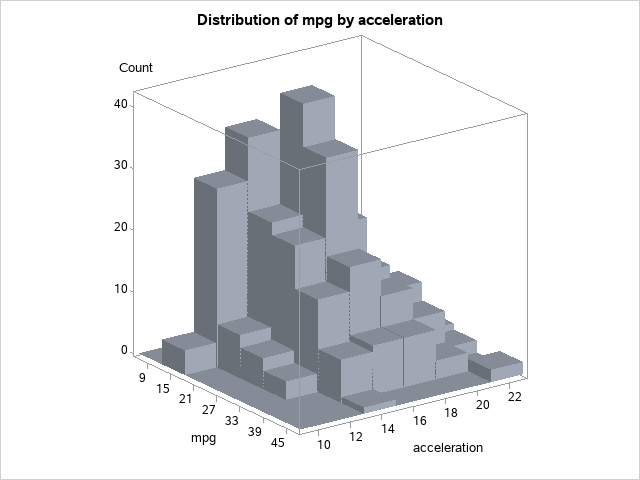
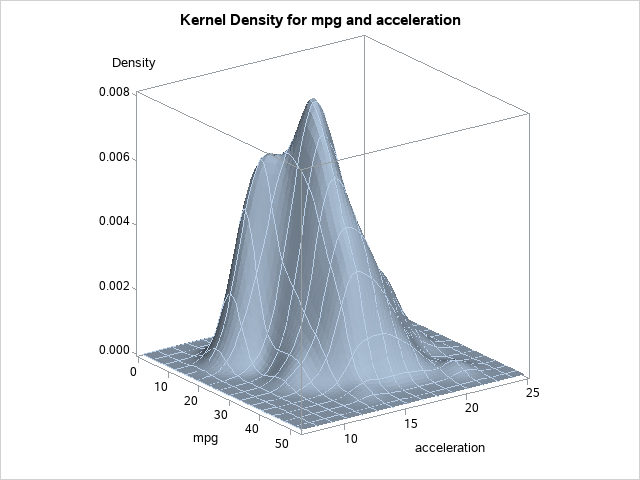

In [24]:
*Create 3D visualizations for checking the impact of different variables on mpg;

proc kde data=auto.log_data;
 bivar mpg cylinders / noprint plots = histogram surface;
 bivar mpg displacement / noprint plots = histogram surface;
 bivar mpg horsepower / noprint plots = histogram surface;
 bivar mpg weight / noprint plots = histogram surface;
 bivar mpg model_year / noprint plots = histogram surface;
 bivar mpg acceleration / noprint plots = histogram surface;
run;